In [9]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from scipy.special import expit as logistic

In [73]:
d = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/chimpanzees.csv", sep = ";")
# create treatment variable
d["treatment"] = d["prosoc_left"] + 2* d["condition"] # needs to startat 0 for pm to work

#actor needs to start at 0 for pm to work
d["actor"] = d["actor"] - 1

In [74]:
d.groupby("treatment")[["prosoc_left", "condition"]].mean()

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


Model 11_1:


$L_i \sim Binomial(1, p_i)$

$logit(p_i) = \alpha$

$\alpha \sim Normal(0, 10)$

In [31]:
m11_1 = pm.Model()
with m11_1:
    a = pm.Normal("a", 0, 10)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_1_prior = pm.sample_prior_predictive()

In [42]:
m11_1b = pm.Model()
with m11_1b:
    a = pm.Normal("a", 0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_1b_prior = pm.sample_prior_predictive()

Model 11_2:


$L_i \sim Binomial(1, p_i)$

$logit(p_i) = \alpha + \beta_{treatment}$

$\alpha \sim Normal(0, 10)$

In [51]:
with pm.Model() as m11_2:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 10, shape = 4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[d.treatment]))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_2_prior = pm.sample_prior_predictive()

In [52]:
with pm.Model() as m11_2b:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 1.5, shape = 4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[d.treatment]))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_2b_prior = pm.sample_prior_predictive()

In [69]:
# extract alphas
a1 = m11_1_prior["p"]
a2 = m11_1b_prior["p"]

#extract difference between treatment 1 and treatment 2
b1_treat_1, b1_treat_2 = (
    logistic(m11_2_prior["a"] + m11_2_prior["b"][:,0]),
    logistic(m11_2_prior["a"] + m11_2_prior["b"][:,1]))
b2_treat_1, b2_treat_2 = (
    logistic(m11_2b_prior["a"] + m11_2b_prior["b"][:,0]),
    logistic(m11_2b_prior["a"] + m11_2b_prior["b"][:,1]))

b1 = np.abs(b1_treat_1 - b1_treat_2)
b2 = np.abs(b2_treat_1 - b2_treat_2)

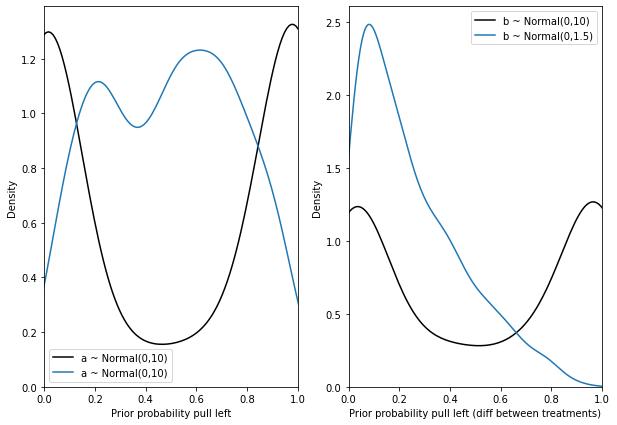

In [71]:
fig, ax = plt.subplots(1,2, figsize = (10,7))
#plot alpha
ax[0].set_xlim(0,1)
sns.kdeplot(a1, ax = ax[0], color = "black", label = "a ~ Normal(0,10)")
sns.kdeplot(a2, ax = ax[0], label = "a ~ Normal(0,10)")
ax[0].set_xlabel("Prior probability pull left")
ax[0].legend()
#plot beta
ax[1].set_xlim(0,1)
sns.kdeplot(b1, ax = ax[1], color = "black", label = "b ~ Normal(0,10)")
sns.kdeplot(b2, ax = ax[1], label = "b ~ Normal(0,1.5)")
ax[1].set_xlabel("Prior probability pull left (diff between treatments)")
ax[1].legend()

plt.show()

In [78]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0, 1.5, shape = d.actor.nunique())
    b = pm.Normal("b", 0, 1.5, shape = d.treatment.nunique())
    p = pm.Deterministic("p", pm.math.invlogit(a[d.actor] + b[d.treatment]))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [81]:
az.summary(m11_4_trace, var_names = ["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.783,0.529,-1.742,0.225,0.018,0.013,895.0,891.0,898.0,1406.0,1.00
a[1],3.673,0.845,2.104,5.247,0.022,0.016,1514.0,1477.0,1533.0,2022.0,1.00
a[2],-1.077,0.533,-2.081,-0.100,0.018,0.013,901.0,901.0,902.0,1434.0,1.00
a[3],-1.086,0.527,-2.060,-0.093,0.018,0.012,904.0,893.0,907.0,1210.0,1.01
a[4],-0.781,0.527,-1.762,0.189,0.018,0.013,882.0,868.0,884.0,1241.0,1.01
a[5],0.158,0.524,-0.840,1.085,0.018,0.013,868.0,868.0,870.0,1405.0,1.00
a[6],1.662,0.580,0.560,2.737,0.018,0.013,997.0,997.0,998.0,1599.0,1.00
b[0],0.275,0.510,-0.714,1.176,0.018,0.012,847.0,847.0,848.0,1065.0,1.00
b[1],0.878,0.508,-0.045,1.866,0.018,0.013,816.0,816.0,817.0,1201.0,1.01
b[2],-0.127,0.511,-1.155,0.757,0.018,0.013,821.0,821.0,823.0,1141.0,1.01


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

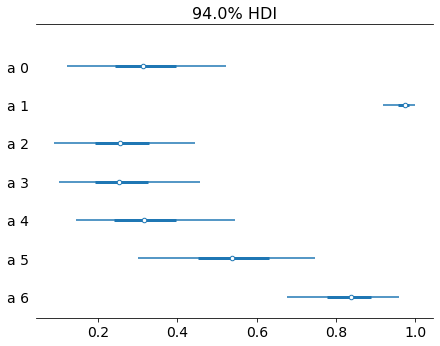

In [87]:
az.plot_forest(m11_4_trace, var_names = "a", transform = logistic, combined = True)

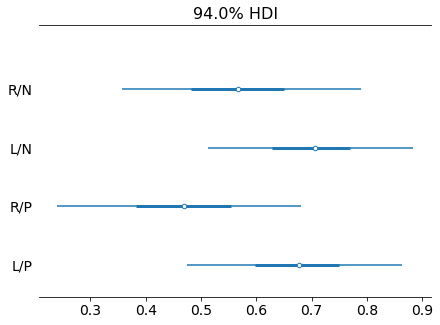

In [93]:
ax = az.plot_forest(m11_4_trace, var_names = "b", transform = logistic, combined = True)
ax[0].set_yticklabels(["L/P", "R/P","L/N", "R/N"])
plt.show()

[Text(0, 0.0, 'db24'), Text(0, 2.25, 'db13')]

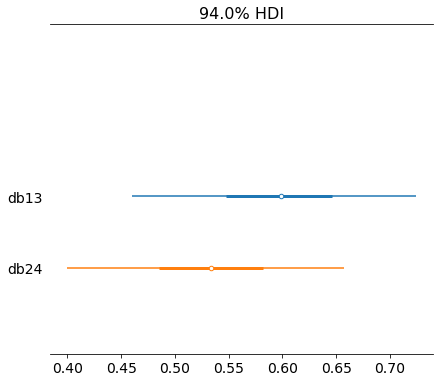

In [99]:
db13 = m11_4_trace["b"][:,0] - m11_4_trace["b"][:,2]
db24 = m11_4_trace["b"][:,1] - m11_4_trace["b"][:,3]
ax = az.plot_forest([db13, db24], transform = logistic, combined = True) #using responsescale so 50% means no difference
ax[0].set_yticklabels(["db24", "db13"])

### Aggregated binominal

In [24]:
d = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/UCBadmit.csv", sep=";")
d

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


$A_i \sim Binomial(N_i, p_i)$

$logit(p_i) = \alpha_{GID[i]}$

$\alpha_j \sim Normal(0, 1.5)$ 

In [90]:
gid = (d["applicant.gender"] == "female").astype(int).values

with pm.Model() as m11_7:
    a = pm.Normal("a", 0, 1.5, shape=2)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    A = pm.Binomial("A", p=p, n=d["applications"],observed = d["admit"].values)
    m11_7_trace = pm.sample()
    m11_7_post = pm.sample_posterior_predictive(m11_7_trace, var_names=["A"])["A"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [32]:
az.summary(m11_7_trace, var_names="a")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.220,0.040,-0.296,-0.147,0.001,0.000,3266.0,3189.0,3258.0,2750.0,1.0
a[1],-0.829,0.052,-0.926,-0.732,0.001,0.001,3633.0,3633.0,3636.0,2937.0,1.0


In [41]:
diff_a = m11_7_trace["a"][:,0] - m11_7_trace["a"][:,1]
diff_p = logistic(m11_7_trace["a"][:,0]) - logistic(m11_7_trace["a"][:,1])
az.summary({"diff_a": diff_a, "diff_p": diff_p})

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
diff_a,0.609,0.064,0.485,0.725,0.001,0.001,3623.0,3623.0,3630.0,3066.0,NaN
diff_p,0.141,0.015,0.114,0.168,0.000,0.000,3598.0,3598.0,3603.0,2703.0,NaN


In [129]:
(A / d.applications.values).shape

(4000, 12)

Text(0.5, 1.0, 'Posterior predictive check')

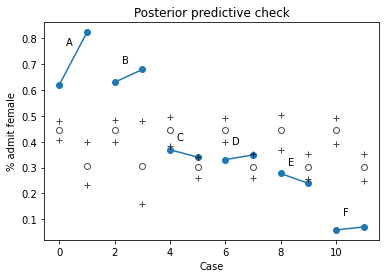

In [147]:
# predicted
A = m11_7_post
A_point = m11_7_post.mean(axis = 0)
P_point = A_point / d.applications.values

#observed
P_obs = d.admit.values / d.applications.values

for i in range(6):
    x = 2 * i
    y1 = P_obs[x]
    y2 = P_obs[x+1]
    plt.plot([x,x+1], [y1,y2], "-C0o", color = "#1f77b4")
    plt.plot([x,x+1], [P_point[x],P_point[x+1]], "ko", color = "black", fillstyle="none", alpha = 0.7)
    plt.text(x=x+0.25, y=np.mean([y1, y2])+0.05, s = d.dept[x+1])

plt.plot(range(12), az.hpd(A / d.applications.values), "k+", color = "black", alpha = 0.7)
plt.xlabel("Case")
plt.ylabel("% admit female")
plt.title("Posterior predictive check")


$A_i \sim Binomial(N_i, p_i)$

$logit(p_i) = \alpha_{GID[i]} + \sigma_{DEPT[i]}$

$\alpha_j \sim Normal(0, 1.5)$ 

$\sigma_j \sim Normal(0, 1.5)$

In [187]:
d.dept_cat = pd.Categorical(d.dept).codes

with pm.Model() as m11_8:
    a = pm.Normal("a", 0, 1.5, shape=2)
    s = pm.Normal("s", 0, 1.5, shape=6)
    p = pm.Deterministic("p", pm.math.invlogit(a[gid] + s[d.dept_cat]))
    A = pm.Binomial("A", p=p, n=d["applications"],observed = d["admit"].values)
    m11_8_trace = pm.sample()
    m11_8_post = pm.sample_posterior_predictive(m11_8_trace, var_names="A")["A"]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.6918070791226426, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [154]:
az.summary(m11_8_trace, var_names = ["a", "s"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.558,0.524,-1.512,0.419,0.026,0.018,419.0,419.0,430.0,487.0,1.01
a[1],-0.458,0.524,-1.464,0.463,0.026,0.018,418.0,418.0,426.0,490.0,1.01
s[0],1.138,0.527,0.151,2.096,0.026,0.018,423.0,423.0,433.0,484.0,1.01
s[1],1.095,0.530,0.195,2.155,0.026,0.018,427.0,427.0,437.0,471.0,1.01
s[2],-0.123,0.526,-1.114,0.826,0.026,0.019,418.0,366.0,427.0,457.0,1.01
s[3],-0.154,0.527,-1.136,0.813,0.026,0.020,421.0,359.0,432.0,498.0,1.01
s[4],-0.600,0.529,-1.569,0.387,0.026,0.019,425.0,393.0,432.0,495.0,1.01
s[5],-2.158,0.539,-3.093,-1.068,0.026,0.019,436.0,423.0,445.0,555.0,1.01


In [155]:
diff_a = m11_8_trace["a"][:,0] - m11_8_trace["a"][:,1]
diff_p = logistic(m11_8_trace["a"][:,0]) - logistic(m11_8_trace["a"][:,1])
az.summary({"diff_a": diff_a, "diff_p": diff_p})

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
diff_a,-0.100,0.080,-0.249,0.051,0.001,0.001,4240.0,3730.0,4244.0,3381.0,NaN
diff_p,-0.022,0.018,-0.056,0.012,0.000,0.000,3795.0,3164.0,3818.0,3214.0,NaN


In [158]:
d.groupby(["dept", "applicant.gender"]).applications.sum() / d.

dept  applicant.gender
A     female              108
      male                825
B     female               25
      male                560
C     female              593
      male                325
D     female              375
      male                417
E     female              393
      male                191
F     female              341
      male                373
Name: applications, dtype: int64

In [184]:
piv = d.groupby(["dept", "applicant.gender"], as_index=False).applications.sum().pivot("dept", "applicant.gender")
piv.values / piv.sum(axis=1).values.reshape(6,1)

array([[0.11575563, 0.88424437],
       [0.04273504, 0.95726496],
       [0.6459695 , 0.3540305 ],
       [0.47348485, 0.52651515],
       [0.67294521, 0.32705479],
       [0.47759104, 0.52240896]])

Text(0.5, 1.0, 'Posterior predictive check')

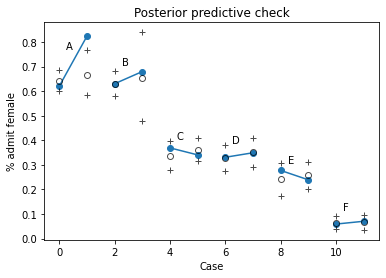

In [188]:
# predicted
A = m11_8_post
A_point = m11_8_post.mean(axis = 0)
P_point = A_point / d.applications.values

#observed
P_obs = d.admit.values / d.applications.values

for i in range(6):
    x = 2 * i
    y1 = P_obs[x]
    y2 = P_obs[x+1]
    plt.plot([x,x+1], [y1,y2], "-C0o", color = "#1f77b4")
    plt.plot([x,x+1], [P_point[x],P_point[x+1]], "ko", color = "black", fillstyle="none", alpha = 0.7)
    plt.text(x=x+0.25, y=np.mean([y1, y2])+0.05, s = d.dept[x+1])

plt.plot(range(12), az.hpd(A / d.applications.values), "k+", color = "black", alpha = 0.7)
plt.xlabel("Case")
plt.ylabel("% admit female")
plt.title("Posterior predictive check")


### Poisson model

In [8]:
d = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Kline.csv", sep=";")
d["contact_id"] = np.array(d.contact=="high").astype(int)
d

,culture,population,contact,total_tools,mean_TU,contact_id
0,Malekula,1100,low,13,3.2,0
1,Tikopia,1500,low,22,4.7,0
2,Santa Cruz,3600,low,24,4.0,0
3,Yap,4791,high,43,5.0,1
4,Lau Fiji,7400,high,33,5.0,1
5,Trobriand,8000,high,19,4.0,1
6,Chuuk,9200,high,40,3.8,1
7,Manus,13000,low,28,6.6,0
8,Tonga,17500,high,55,5.4,1
9,Hawaii,275000,low,71,6.6,0


$T_i \sim Poisson(\lambda_i)$

$log\lambda = \alpha$

$\alpha_j \sim Normal(0, 10)$

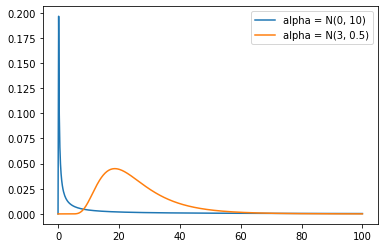

In [37]:
x = np.linspace(start=0, stop=100, num=500)
a_0 = stats.lognorm.pdf(loc=0, scale=np.exp(0), s = 10, x = x)
a_3 = stats.lognorm.pdf(loc=3, scale=np.exp(3), s = 0.5, x = x)
plt.plot(x, a_0, label = "alpha = N(0, 10)")
plt.plot(x, a_3, label = "alpha = N(3, 0.5)")
plt.xlabel("Mean number of tools")
plt.legend()

$T_i \sim Poisson(\lambda_i)$

$log\lambda = \alpha_{CID[i]} + \beta_{CID[i]} logP_i$

$\alpha_j \sim Normal(0, 10)$

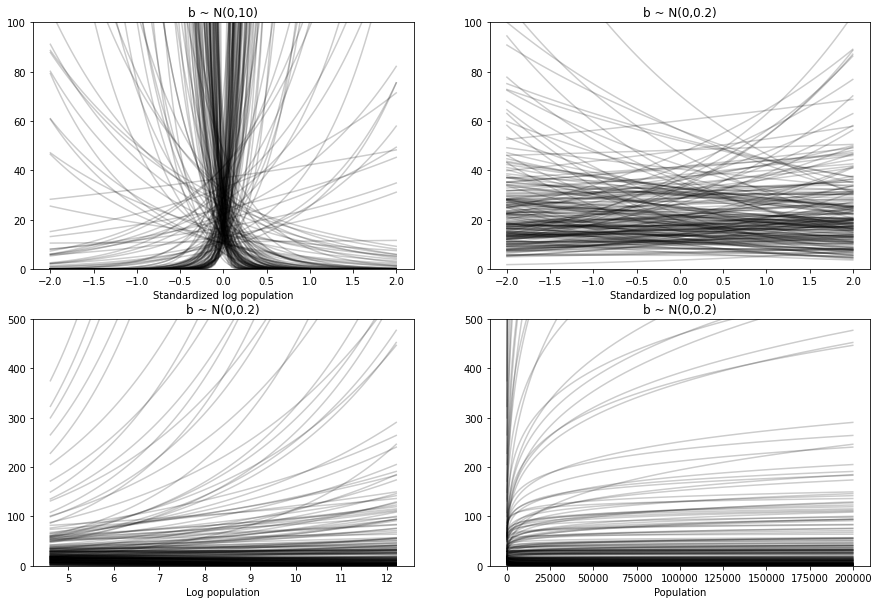

In [64]:
x_std = np.linspace(start=-2,stop=2,num=100)
x_log = np.linspace(start=np.log(100),stop=np.log(200000),num=100)
N = 200

a = stats.norm.rvs(loc = 3, scale = 0.5, size = N)
b1 = stats.norm.rvs(loc = 0, scale = 10,size = N)
b2 = stats.norm.rvs(loc = 0, scale = 0.2,size = N)

fig, ax = plt.subplots(2,2, figsize = (15, 10))
for n in range(N):
    y1 = np.exp(a[n] + b1[n] * x_std)
    y2 = np.exp(a[n] + b2[n] * x_std)
    y3 = np.exp(a[n] + b2[n] * x_log)
    ax[0,0].plot(x_std, y1, alpha = 0.2, color = "black")
    ax[0,0].set_ylim(0,100)
    ax[0,0].set_title("b ~ N(0,10)")
    ax[0,0].set_xlabel("Standardized log population")
    ax[0,1].plot(x_std, y2, alpha = 0.2, color = "black")
    ax[0,1].set_ylim(0,100)
    ax[0,1].set_title("b ~ N(0,0.2)")
    ax[0,1].set_xlabel("Standardized log population")
    ax[1,0].plot(x_log, y3, alpha = 0.2, color = "black")
    ax[1,0].set_title("b ~ N(0,0.2)")
    ax[1,0].set_xlabel("Log population")
    ax[1,0].set_ylim(0,500)
    ax[1,1].plot(np.exp(x_log), y3, alpha = 0.2, color = "black")
    ax[1,1].set_title("b ~ N(0,0.2)")
    ax[1,1].set_xlabel("Population")
    ax[1,1].set_ylim(0,500)

0.1371742112482853